# 計算グラフによる MLP 実装

In [1]:
import numpy
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

def plot(classifier, data, labels, title=None, xlabel=None, ylabel=None):
    unique_labels = np.unique(labels)
    colors = ['red', 'blue', 'green', 'orange', 'cyan'][:len(unique_labels)]
    x1max, x1min = np.max(data[:, 0]), np.min(data[:, 0])
    x2max, x2min = np.max(data[:, 1]), np.min(data[:, 1])
    scale_x1 = x1max - x1min
    scale_x2 = x2max - x2min
    x1max, x1min = x1max + (x1max-x1min)*0.05, x1min - (x1max-x1min)*0.05
    x2max, x2min = x2max + (x2max-x2min)*0.05, x2min - (x2max-x2min)*0.05
    resolution = scale_x1 / 200
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors))
    
    data_of_each_label = {}
    for d, l in zip(data, labels):
        if l in data_of_each_label:
            data_of_each_label[l].append(d)
        else:
            data_of_each_label[l] = [d]
    
    for i in range(len(unique_labels)):
        data = data_of_each_label[unique_labels[i]]
        plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=5, c=colors[i])

In [2]:
import numpy as np
from abc import ABCMeta, abstractmethod

class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class Affine(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A_with_bias = None

    def forward(self, A):
        self.A_with_bias = np.full((A.shape[0]+1, A.shape[1]), 1.0)
        self.A_with_bias[1:] = A
        out = np.dot(self.W, self.A_with_bias)
        return out

    def backward(self, dout):
        dA = np.dot(self.W.T[1:], dout)
        self.dW = np.dot(dout, self.A_with_bias.T)
        return dA


class Sigmoid(MLPLayer):
    def __init__(self):
        self.sigmoid = None
    
    def forward(self, Z):
        self.sigmoid = 1.0 / (1.0 + np.exp(-Z))
        return self.sigmoid
    
    def backward(self, dout):
        dphi = self.sigmoid * (1.0 - self.sigmoid)
        dZ = dout * dphi
        return dZ


class HyperbolicTangent(MLPLayer):
    def __init__(self):
        self.Z = None
    
    def forward(self, Z):
        self.Z = Z
        out = np.tanh(Z)
        return out
    
    def backward(self, dout):
        dphi = 1.0 / np.cosh(self.Z)**2
        dZ = dout * dphi
        return dZ


class ReLU(MLPLayer):
    def __init__(self):
        self.mask = None
    
    def forward(self, Z):
        self.mask = Z <= 0
        out = Z.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dphi = np.full(self.mask.shape, 1.0)
        dphi[self.mask] = 0
        dZ = dout * dphi
        return dZ


class SoftMax(MLPLayer):
    def __init__(self):
        self.Y = None
    
    def forward(self, Z):
        Z_exp = np.exp(Z)
        self.Y = Z_exp / Z_exp.sum(axis=0)
        return self.Y
    
    def backward(self, dout):
        dZ = self.Y * (dout - np.sum(self.Y * dout, axis=0))
        return dZ


class CostCalculation(MLPLayer):
    def __init__(self):
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct):
        self.Y_predict = Y_predict
        self.Y_correct = Y_correct
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=0)
        cost = np.average(cost)
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[1]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict)) / batch_size
        return dA


class BatchNormalization(MLPLayer):
    def __init__(self, h_units, eps=1e-8, gamma=1.0, beta=0):
        self.h_units = h_units
        self.eps = eps
        self.gamma = gamma
        self.beta = beta
        self.std = None
        self.Z_norm = None
        self.dgamma = None
        self.dbeta = None
    
    def forward(self, Z):
        mu = np.average(Z, axis=0)
        self.std = np.std(Z, axis=0)
        self.Z_norm = (Z - mu) / np.sqrt(self.std**2 + self.eps)
        out = self.gamma * self.Z_norm + self.beta
        return out
    
    def backward(self, dout):
        self.dgamma = (dout * self.Z_norm).sum(axis=0)
        self.dbeta = dout.sum(axis=0)
        dZ = self.gamma / (self.h_units * np.sqrt(self.std**2 + self.eps)) * (
            self.h_units * dout - self.dbeta - self.Z_norm * self.dgamma
        )
        return dZ

In [119]:
import copy
import numpy as np

class MLPClassifier:
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, l2=0.,
                 hidden_activation_class=HyperbolicTangent, debug_grad_check=False, debug_activation_hist=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.hidden_activation_class = hidden_activation_class
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.n = None
        self.m = None
        self.t = None
        self.cost = None
        self.mse = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = []
        self.debug_activation_hist = debug_activation_hist
        self.activation_hist = []
    
    def predict(self, data):
        out = np.matrix(data).T
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=0)
        return self.index2label[i_label]
    
    def fit(self, data, labels):
        self.index2label = np.unique(labels)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        self.n = len(data)
        self.m = len(data[0])
        self.t = len(self.index2label)
        
        X = data.T
        Y = np.zeros([self.t, self.n])
        for i in range(self.n):
            l = labels[i]
            Y[self.label2index[l]][i] = 1.0
        
        # 重みの初期化
        W = []
        W.append(np.random.randn(self.h_units, self.m+1) * np.sqrt(1.0/(self.m+1)))
        for i in range(self.h_layers-1):
            W.append(np.random.randn(self.h_units, self.h_units+1) * np.sqrt(1.0/(self.h_units+1)))
        W.append(np.random.randn(self.t, self.h_units+1) * np.sqrt(1.0/(self.h_units+1)))
        
        # レイヤの初期化
        self.layers = []
        for i in range(self.h_layers):
            self.layers.append(Affine(W[i]))
            self.layers.append(BatchNormalization(self.h_units))
            self.layers.append(self.hidden_activation_class())
        self.layers.append(Affine(W[-1]))
        self.layers.append(SoftMax())
        self.cost_layer = CostCalculation()
        
        self.cost = []
        self.mse = []
        for _ in range(self.epochs):
            # ミニバッチデータ選択
            ids = np.random.choice(range(self.n), self.n_batch, replace=False)
            X_part = X[:, ids]
            Y_part = Y[:, ids]
            
            # フォワードプロパゲーション
            out = X_part
            if self.debug_activation_hist:
                # デバッグ: 活性化関数の出力分布
                self.activation_hist.append([])
            for layer in self.layers:
                out = layer.forward(out)
                if self.debug_activation_hist and isinstance(layer, self.hidden_activation_class):
                    # デバッグ: 活性化関数の出力分布
                    self.activation_hist[-1].append(np.histogram(out, bins=20))
            cost = self.cost_layer.forward(out, Y_part)
            self.cost.append(cost)
            
            # 誤差計算
            mse = np.sum((Y_part - out)**2) / self.n_batch
            self.mse.append(mse)
            if mse < 1e-3:
                break
        
            # バックプロパゲーション
            dout = self.cost_layer.backward()
            for layer in self.layers[::-1]:
                dout = layer.backward(dout)
            
            # L2正則化項を勾配に追加
            for layer in self.layers:
                if isinstance(layer, Affine):
                    layer.dW += self.l2 * layer.W
                elif isinstance(layer, BatchNormalization):
                    layer.dgamma += self.l2 * layer.gamma
                    layer.dbeta += self.l2 * layer.beta
            
            # デバッグ: Gradient Checking
            if self.debug_grad_check:
                grad = [layer.dW for layer in self.layers if isinstance(layer, Affine)]
                self.__check_gradient(X_part, Y_part, grad)
            
            # パラメータの更新
            self.__update()
    
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.W -= self.eta * layer.dW
            elif isinstance(layer, BatchNormalization):
                layer.gamma -= self.eta * layer.dgamma.sum()
                layer.beta -= self.eta * layer.dbeta.sum()

    def __check_gradient(self, X, Y, grad):
        """
        Gradient Checking
        - デバッグ用メソッド
        - 誤差伝播による微分と数値微分を比較する
        """
        layers_tmp = copy.deepcopy(self.layers)
        cost_layer_tmp = copy.deepcopy(self.cost_layer)
        eps = 1e-6
        grad_num = []
        for l in range(len(layers_tmp)):
            if not isinstance(layers_tmp[l], Affine):
                continue
            g = np.zeros(layers_tmp[l].W.shape)
            for i in range(layers_tmp[l].W.shape[0]):
                for j in range(layers_tmp[l].W.shape[1]):
                    layers_tmp[l].W[i][j] -= eps
                    out = X
                    for layer in layers_tmp:
                        out = layer.forward(out)
                    cost1 = cost_layer_tmp.forward(out, Y) + layers_tmp[l].W[i][j]**2 * self.l2 / 2.0 # 正則化項は差分があるもののだけを加える
                    layers_tmp[l].W[i][j] += eps
                    
                    layers_tmp[l].W[i][j] += eps
                    out = X
                    for layer in layers_tmp:
                        out = layer.forward(out)
                    cost2 = cost_layer_tmp.forward(out, Y) + layers_tmp[l].W[i][j]**2 * self.l2 / 2.0
                    layers_tmp[l].W[i][j] -= eps
                    
                    g[i][j] = (cost2 - cost1) / eps / 2.0
            grad_num.append(g)
        vec_grad_num = np.hstack(tuple([g.flatten() for g in grad_num]))
        vec_grad = np.hstack(tuple([g.flatten() for g in grad]))
        relative_err = np.linalg.norm(vec_grad_num-vec_grad) / (np.linalg.norm(vec_grad_num) + np.linalg.norm(vec_grad))
        self.grad_err.append(relative_err)

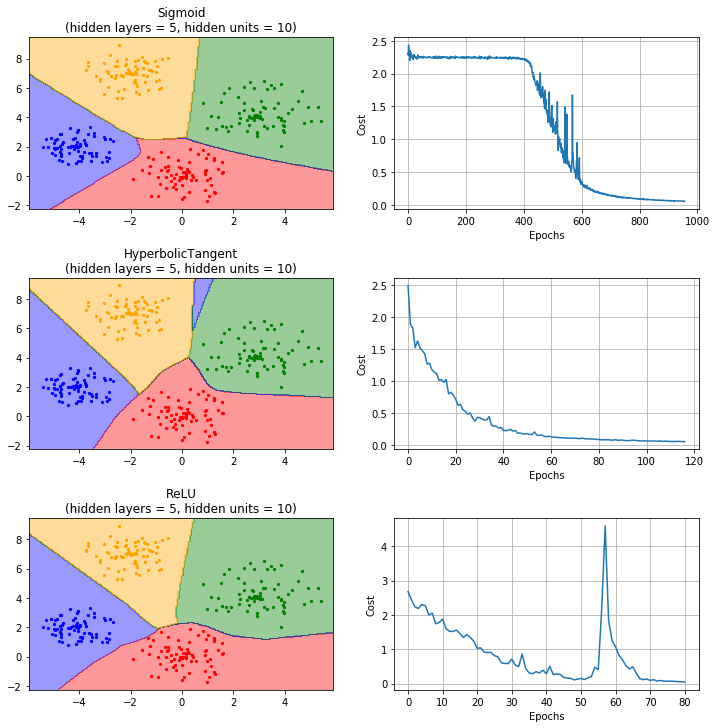

In [123]:
import numpy
from matplotlib import pyplot as plt

# データ作成
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])


# 学習の設定
activation_classes = [Sigmoid, HyperbolicTangent, ReLU]
H_LAYERS = 5
H_UNITS = 10


# 決定領域の描画
plt.figure(figsize=(12, 4*len(activation_classes)))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for i in range(len(activation_classes)):
    mlp = MLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=10000, eta=0.05, n_batch=50,
                        hidden_activation_class=activation_classes[i])
    mlp.fit(data, labels)
    plt.subplot(len(activation_classes), 2, 2*i+1)
    plt.title('{}\n(hidden layers = {}, hidden units = {})'.format(activation_classes[i].__name__, H_LAYERS, H_UNITS))
    # 決定領域描画のための自作関数
    plot(mlp, data, labels)
    plt.subplot(len(activation_classes), 2, 2*i+2)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(range(len(mlp.cost)), mlp.cost)
    plt.grid()
plt.show()

In [128]:
# デバッグ: Gradient Checking
for l2 in [0, 0.1]:
    for act_class in activation_classes:
        print('---------- {} (lambda = {}) ----------'.format(act_class.__name__, l2))
        mlp = MLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=10, eta=0.01, n_batch=50,
                            hidden_activation_class=act_class, debug_grad_check=True)
        mlp.fit(data, labels)
        for err in mlp.grad_err:
            print(err)
"""
---------- Sigmoid ----------
2.485041935250212e-09
1.6110953348237e-09
1.3252066720530073e-09
1.5442469563287938e-09
2.113446583797843e-09
3.098827546539961e-09
2.7577788202542225e-09
1.6582474875794635e-09
1.9847572956477425e-09
2.337037934091913e-09
---------- HyperbolicTangent ----------
7.018154954319371e-10
5.831830020936647e-10
4.727378518442104e-10
5.569780224201066e-10
4.96996696490888e-10
7.830670276161226e-10
5.521719096999938e-10
8.178412176001765e-10
4.872008065560422e-10
7.199715101455174e-10
---------- ReLU ----------
7.241023402690478e-10
6.206161363792163e-10
9.450623157994923e-10
7.619912392935605e-10
7.579858364732872e-10
7.653678027337268e-10
7.837096667005966e-10
8.116935057567349e-10
9.201721183578199e-10
6.956695553326158e-10
"""

---------- Sigmoid (lambda = 0) ----------
3.592127483314902e-09
2.7428418698145356e-09
2.2312253563248398e-08
6.473615796013109e-09
3.000649859621446e-09
7.078556009128112e-09
7.850966020643875e-09
6.626012455508257e-09
4.229127818407494e-09
1.0366860807553768e-08
---------- HyperbolicTangent (lambda = 0) ----------
5.634924504205755e-10
6.879184226055694e-10
7.764821774400488e-10
9.02025811545401e-10
9.280761878660705e-10
9.919511550900553e-10
9.066569314198044e-10
9.975899556313758e-10
1.3460639297354415e-09
1.3216587291834889e-09
---------- ReLU (lambda = 0) ----------
8.258015960410555e-10
9.904130541507855e-10
8.438342788208992e-10
8.803456043621477e-10
6.587428425235377e-10
5.766108856047031e-10
8.435416437310865e-10
8.197197322149211e-10
6.405953331586994e-10
8.439610346385718e-10
---------- Sigmoid (lambda = 0.1) ----------
1.6746170384868106e-09
1.875951479988102e-09
1.7667845384093897e-09
1.6070330221908102e-09
1.650691397980537e-09
1.712239437866763e-09
1.8469289184338777e-

'\n---------- Sigmoid ----------\n2.485041935250212e-09\n1.6110953348237e-09\n1.3252066720530073e-09\n1.5442469563287938e-09\n2.113446583797843e-09\n3.098827546539961e-09\n2.7577788202542225e-09\n1.6582474875794635e-09\n1.9847572956477425e-09\n2.337037934091913e-09\n---------- HyperbolicTangent ----------\n7.018154954319371e-10\n5.831830020936647e-10\n4.727378518442104e-10\n5.569780224201066e-10\n4.96996696490888e-10\n7.830670276161226e-10\n5.521719096999938e-10\n8.178412176001765e-10\n4.872008065560422e-10\n7.199715101455174e-10\n---------- ReLU ----------\n7.241023402690478e-10\n6.206161363792163e-10\n9.450623157994923e-10\n7.619912392935605e-10\n7.579858364732872e-10\n7.653678027337268e-10\n7.837096667005966e-10\n8.116935057567349e-10\n9.201721183578199e-10\n6.956695553326158e-10\n'

In [ ]:
# デバッグ: 活性化関数の出力分布
for act_class in activation_classes:
    print('---------- {} ----------'.format(act_class.__name__))
    mlp = MLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=4, eta=0.01, n_batch=50,
                        hidden_activation_class=act_class, debug_activation_hist=True)
    mlp.fit(data, labels)
    n_epoch = len(mlp.activation_hist)
    n_layer = len(mlp.activation_hist[0])
    plt.figure(figsize=(2*n_layer, 2*n_epoch))
    for t in range(n_epoch):
        for l in range(n_layer):
            hist, bins = mlp.activation_hist[t][l]
            width = (bins[-1] - bins[0]) / (len(bins)-1)
            bins = (bins[:-1] + bins[1:]) / 2.0
            plt.subplot(n_epoch, n_layer, t*n_layer+l+1)
            if t == 0:
                plt.title('Layer {}'.format(l+1), fontsize=10)
            if l == 0:
                plt.ylabel('Epoch {}'.format(t+1), fontsize=10)
            plt.bar(bins, hist, width=width)
    plt.show()

# 正則化

うまくいかない。

In [129]:
import copy
import numpy as np

class MLPClassifierL2:
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, l2=0.,
                 hidden_activation_class=HyperbolicTangent, debug_grad_check=False, debug_activation_hist=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.hidden_activation_class = hidden_activation_class
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.n = None
        self.m = None
        self.t = None
        self.cost = None
        self.mse = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = []
        self.debug_activation_hist = debug_activation_hist
        self.activation_hist = []
    
    def predict(self, data):
        out = np.matrix(data).T
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=0)
        return self.index2label[i_label]
    
    #def fit(self, data, labels):
    def fit(self, data, labels, data_test, labels_test):
        self.index2label = np.unique(labels)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        self.n = len(data)
        self.m = len(data[0])
        self.t = len(self.index2label)
        
        # 重みの初期化
        W = []
        W.append(np.random.randn(self.h_units, self.m+1) * np.sqrt(1.0/(self.m+1)))
        for i in range(self.h_layers-1):
            W.append(np.random.randn(self.h_units, self.h_units+1) * np.sqrt(1.0/(self.h_units+1)))
        W.append(np.random.randn(self.t, self.h_units+1) * np.sqrt(1.0/(self.h_units+1)))
        
        # レイヤの初期化
        self.layers = []
        for i in range(self.h_layers):
            self.layers.append(Affine(W[i]))
            self.layers.append(BatchNormalization(self.h_units))
            self.layers.append(self.hidden_activation_class())
        self.layers.append(Affine(W[-1]))
        self.layers.append(SoftMax())
        self.cost_layer = CostCalculation()
        
        X = data.T
        Y = np.zeros([self.t, self.n])
        for i in range(self.n):
            l = labels[i]
            Y[self.label2index[l]][i] = 1.0
        
        self.cost = []
        self.mse = []
        
        
        # FIXME
        X_test = data_test.T
        Y_test = np.zeros([self.t, len(data_test)])
        for i in range(len(data_test)):
            l = labels_test[i]
            Y_test[self.label2index[l]][i] = 1.0
        self.mse_test = []
        
        
        for step in range(self.epochs):
            # ミニバッチデータ選択
            ids = np.random.choice(range(self.n), self.n_batch, replace=False)
            X_part = X[:, ids]
            Y_part = Y[:, ids]
            
            # フォワードプロパゲーション
            out = X_part
            if self.debug_activation_hist:
                # デバッグ: 活性化関数の出力分布
                self.activation_hist.append([])
            for layer in self.layers:
                out = layer.forward(out)
                if self.debug_activation_hist and isinstance(layer, self.hidden_activation_class):
                    # デバッグ: 活性化関数の出力分布
                    self.activation_hist[-1].append(np.histogram(out, bins=20))
            cost = self.cost_layer.forward(out, Y_part)
            self.cost.append(cost)
            
            # 誤差計算
            #mse = np.sum((Y_part - out)**2) / self.n_batch
            #self.mse.append(mse)
            #if mse < 1e-3:
            #    break
        
            # バックプロパゲーション
            dout = self.cost_layer.backward()
            for layer in self.layers[::-1]:
                dout = layer.backward(dout)
            
            # L2正則化項を勾配に追加
            for layer in self.layers:
                if isinstance(layer, Affine):
                    layer.dW += self.l2 * layer.W
                elif isinstance(layer, BatchNormalization):
                    layer.dgamma += self.l2 * layer.gamma
                    layer.dbeta += self.l2 * layer.beta
            
            # デバッグ: Gradient Checking
            if self.debug_grad_check:
                grad = [layer.dW for layer in self.layers if isinstance(layer, Affine)]
                self.__check_gradient(X_part, Y_part, grad)
            
            # パラメータの更新
            self.__update()
            
            # FIXME
            if step % 100 == 0:
                out = X_test
                for layer in self.layers:
                    out = layer.forward(out)
                mse = np.sum((Y_test - out)**2) / len(data_test)
                self.mse_test.append(mse)
                out = X
                for layer in self.layers:
                    out = layer.forward(out)
                mse = np.sum((Y - out)**2) / len(data_test)
                self.mse.append(mse)
    
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.W -= self.eta * layer.dW
            elif isinstance(layer, BatchNormalization):
                layer.gamma -= self.eta * layer.dgamma.sum()
                layer.beta -= self.eta * layer.dbeta.sum()

    def __check_gradient(self, X, Y, grad):
        """
        Gradient Checking
        - デバッグ用メソッド
        - 誤差伝播による微分と数値微分を比較する
        """
        layers_tmp = copy.deepcopy(self.layers)
        cost_layer_tmp = copy.deepcopy(self.cost_layer)
        eps = 1e-6
        grad_num = []
        for l in range(len(layers_tmp)):
            if not isinstance(layers_tmp[l], Affine):
                continue
            g = np.zeros(layers_tmp[l].W.shape)
            for i in range(layers_tmp[l].W.shape[0]):
                for j in range(layers_tmp[l].W.shape[1]):
                    layers_tmp[l].W[i][j] -= eps
                    out = X
                    for layer in layers_tmp:
                        out = layer.forward(out)
                    cost1 = cost_layer_tmp.forward(out, Y)
                    
                    layers_tmp[l].W[i][j] += 2*eps
                    out = X
                    for layer in layers_tmp:
                        out = layer.forward(out)
                    cost2 = cost_layer_tmp.forward(out, Y)
                    
                    layers_tmp[l].W[i][j] -= eps
                    g[i][j] = (cost2 - cost1) / eps / 2.0
            grad_num.append(g)
        vec_grad_num = np.hstack(tuple([g.flatten() for g in grad_num]))
        vec_grad = np.hstack(tuple([g.flatten() for g in grad]))
        relative_err = np.linalg.norm(vec_grad_num-vec_grad) / (np.linalg.norm(vec_grad_num) + np.linalg.norm(vec_grad))
        self.grad_err.append(relative_err)

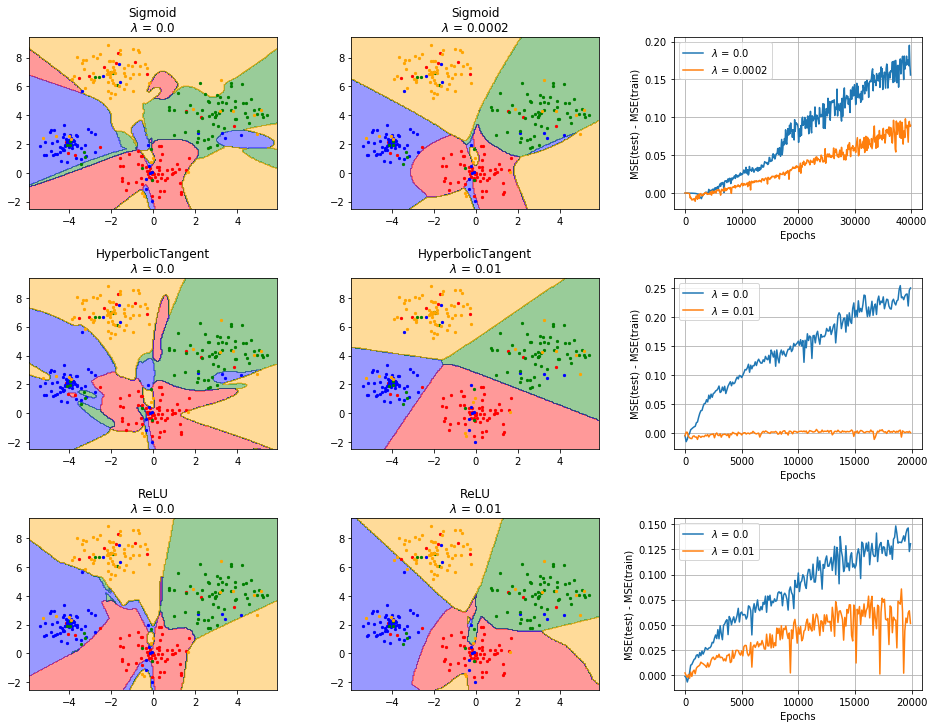

In [135]:
import numpy
from matplotlib import pyplot as plt

# データ作成
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])
data_test = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels_test = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])
for _ in range(N//7):
    i, j = np.random.choice(N, 2, replace=False)
    labels[i], labels[j] = labels[j], labels[i]
    labels_test[i], labels_test[j] = labels_test[j], labels_test[i]


# 学習の設定
activation_classes = [Sigmoid, HyperbolicTangent, ReLU]
H_LAYERS = 3
H_UNITS = 10
epochs = [40000, 20000, 20000]
l2 = [0.0002, 0.01, 0.01]

# 決定領域の描画
plt.figure(figsize=(16, 4*len(activation_classes)))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
for i in range(len(activation_classes)):
    mlp = MLPClassifierL2(h_layers=H_LAYERS, h_units=H_UNITS, epochs=epochs[i], eta=0.01, n_batch=50, l2=0.0,
                        hidden_activation_class=activation_classes[i])
    mlp_l2 = MLPClassifierL2(h_layers=H_LAYERS, h_units=H_UNITS, epochs=epochs[i], eta=0.01, n_batch=50, l2=l2[i],
                        hidden_activation_class=activation_classes[i])
    mlp.fit(data, labels, data_test, labels_test)
    mlp_l2.fit(data, labels, data_test, labels_test)
    plt.subplot(len(activation_classes), 3, 3*i+1)
    plt.title('{}\n$\lambda$ = {}'.format(activation_classes[i].__name__, mlp.l2))
    # 決定領域描画のための自作関数
    plot(mlp, data, labels)
    plt.subplot(len(activation_classes), 3, 3*i+2)
    plt.title('{}\n$\lambda$ = {}'.format(activation_classes[i].__name__, mlp_l2.l2))
    plot(mlp_l2, data, labels)
    #plt.plot(range(len(mlp.mse)), mlp.mse)
    #plt.plot(range(len(mlp.mse_test)), mlp.mse_test)
    
    plt.subplot(len(activation_classes), 3, 3*i+3)
    plt.xlabel('Epochs')
    plt.ylabel('MSE(test) - MSE(train)')
    plt.plot(np.array(range(len(mlp.mse_test)))*100, np.array(mlp.mse_test)-np.array(mlp.mse), label='$\lambda$ = {}'.format(mlp.l2))
    plt.plot(np.array(range(len(mlp_l2.mse_test)))*100, np.array(mlp_l2.mse_test)-np.array(mlp_l2.mse), label='$\lambda$ = {}'.format(mlp_l2.l2))
    #plt.plot(np.array(range(len(mlp_l2.mse_test)))*100, np.array(mlp_l2.mse_test), label='test')
    #plt.plot(np.array(range(len(mlp_l2.mse)))*100, np.array(mlp_l2.mse), label='train')
    plt.legend()
    plt.grid()
    
    """
    plt.subplot(2*len(activation_classes), 2, 2*2*i+3)
    plot(mlp_l2, data, labels)
    
    plt.subplot(2*len(activation_classes), 2, 2*2*i+4)
    #plt.plot(range(len(mlp_l2.mse)), mlp_l2.mse)
    #plt.plot(range(len(mlp_l2.mse_test)), mlp_l2.mse_test)
    plt.plot(range(len(mlp_l2.mse_test)), np.array(mlp_l2.mse_test)-np.array(mlp_l2.mse))
    plt.grid()
    """
plt.show()